In [1]:
%matplotlib inline

In [124]:
import pandas as pd
import numpy as np


N = 1000

p0 = 0.1
p = 0.01
tau = 5

alpha_x = {0: 10, 1: 5, 2: 2}
beta_x =  {0: 1, 1: 1, 2: 1}
lambda_x = {0: 20, 1: 10, 2: 5}

x = np.random.choice([0, 1, 2], size=N)

k = [alpha_x[x_i] for x_i in x]
theta = [1. / beta_x[x_i] for x_i in x]
lambd = [lambda_x[x_i] for x_i in x]
z2 = np.random.gamma(k, theta)
z1 = np.random.poisson(lambd)

y1 = np.random.binomial(1, p=p0 * np.exp(-z2/tau))
y2 = np.random.binomial(z1, p)
y = y1 + y2

df = pd.DataFrame({'X': x, 'Y': y, 'Z_1': z1, 'Z_2': z2, 'Y1': y1, 'Y2': y2})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f490cd10518>,
      dtype=object)

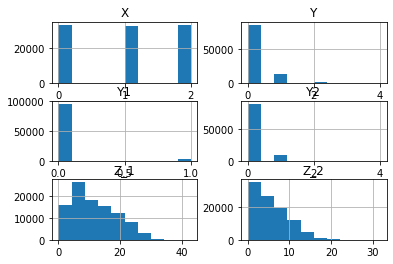

In [67]:
df.hist()

In [68]:
df.groupby('X').mean()['Y']

X
0    0.214732
1    0.139442
2    0.118713
Name: Y, dtype: float64

In [69]:
df.groupby('X').mean()[['Y1', 'Y2', 'Y']]

,Y1,Y2,Y
X,,,
0,0.017003,0.197729,0.214732
1,0.039595,0.099846,0.139442
2,0.069289,0.049424,0.118713


In [141]:
import pandas as pd
import numpy as np


N = 100000

p0 = 0.1
p = 0.01
tau = 5

alpha_x = {0: 10, 1: 5, 2: 2}
beta_x =  {0: 1, 1: 1, 2: 1}
lambda_x = {0: 20, 1: 10, 2: 5}

u = np.random.normal(size=N)

x = np.random.binomial(2, p=1. / (1. + np.exp(-u)))#np.random.choice([0, 1, 2], size=N)

k = [alpha_x[x_i] for x_i in x]
theta = [1. / beta_x[x_i] for x_i in x]
lambd = [lambda_x[x_i] for x_i in x]
z2 = np.random.gamma(k, theta)
z1 = np.random.poisson(lambd)

y1 = np.random.binomial(1, p=p0 * np.exp(-z2/tau))
y2 = np.random.binomial(z1, p)
y = y1 + y2 + np.random.binomial(2, p=1. / (1. + np.exp(-u)))

df = pd.DataFrame({'X': x, 'Y': y, 'Z_1': z1, 'Z_2': z2, 'Y1': y1, 'Y2': y2})

In [149]:
df.groupby('X').mean()['Y']

X
0    0.918449
1    1.139442
2    1.422408
Name: Y, dtype: float64

In [150]:
df.groupby('X').mean()[['Y1', 'Y2', 'Y']]

,Y1,Y2,Y
X,,,
0,0.017321,0.202255,0.918449
1,0.039816,0.101656,1.139442
2,0.068210,0.049855,1.422408


In [142]:
from statsmodels.api import OLS

df['expz2'] = np.exp(-z2/tau)
df['intercept'] = 1.
model = OLS(endog=df['Y'], exog=df[['Z_1', 'expz2', 'X', 'intercept']])

result = model.fit()
df['y_given_z2_x'] = result.predict()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1879.
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:40:17   Log-Likelihood:            -1.2339e+05
No. Observations:              100000   AIC:                         2.468e+05
Df Residuals:                   99996   BIC:                         2.468e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Z_1            0.0110      0.001     15.018      0.000       0.010       0.012
expz2          0.0737      0.018      4.069      0.000       0.038       0.109
X              0.3146      0.008     38.500      0.000       0.299       0.331
intercept      0.6863      0.015     46.688      0.000       0.657       0.715
==============================================================================
Omnibus:                     1777.430   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1612.733
Skew:                           0.264   Prob(JB):                         0.00
Kurtosis:                       2.671   Cond. No.                         96.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [151]:
from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional

p_z1_z2_given_x = KDEMultivariateConditional(endog=df[['Z_1', 'Z_2']], exog=df[['X']], 
                                          dep_type='cc', indep_type='u', 
                                          bw='normal_reference')

In [152]:
px = df.groupby('X').count()

In [153]:
px / len(df)

,Y,Z_1,Z_2,Y1,Y2,expz2,intercept,y_given_z2_x
X,,,,,,,,
0,0.29270,0.29270,0.29270,0.29270,0.29270,0.29270,0.29270,0.29270
1,0.41365,0.41365,0.41365,0.41365,0.41365,0.41365,0.41365,0.41365
2,0.29365,0.29365,0.29365,0.29365,0.29365,0.29365,0.29365,0.29365


In [154]:
p_z1_z2_given_x.bw

array([1.38545476, 0.79874718, 0.15671057])

In [146]:
from scipy.integrate import dblquad

def integrand(z1, z2, x=0):
    f1 = float(p_z1_z2_given_x.pdf(endog_predict=[z1, z2], exog_predict=[x]))
    the_sum = 0.
    for xp in df.X.unique():
        y = result.predict(exog=[z1, np.exp(-z2/tau), xp, 1.])[0]
        p_x = (px / len(df))['Y'][xp]
        the_sum += y * p_x
    return the_sum*f1
        
dblquad(lambda z1, z2: integrand(z1, z2, x=0.), 
        df.Z_1.min() - 1, df.Z_1.max() + 1, 
        df.Z_2.min() - 1, df.Z_2.max() + 1)

(1.165133943679454, 1.644048935377988e-08)

In [147]:
dblquad(lambda z1, z2: integrand(z1, z2, x=1.), 
        df.Z_1.min() - 1, df.Z_1.max() + 1, 
        df.Z_2.min() - 1, df.Z_2.max() + 1)

(1.1401767838909023, 1.6975743067382053e-08)

In [148]:
dblquad(lambda z1, z2: integrand(z1, z2, x=2.), 
        df.Z_1.min() - 1, df.Z_1.max() + 1, 
        df.Z_2.min() - 1, df.Z_2.max() + 1)

(1.1042659136450854, 1.4730014876130089e-08)